In [1]:
%matplotlib inline
import numpy as np
from astropy.table import Table, hstack
import scipy.stats
import dustmaps.bayestar, dustmaps.sfd
import astropy.units as units
from astropy.coordinates import SkyCoord
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
#rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
import matplotlib.pyplot as plt
%cd ..
from starlight.models import SimpleHRDModel
from starlight.models_cy import *
# Some nice colors
cols = [(0.65098041296005249, 0.80784314870834351, 0.89019608497619629),
 (0.12572087695201239, 0.47323337360924367, 0.707327968232772),
 (0.68899655751153521, 0.8681737867056154, 0.54376011946622071),
 (0.21171857311445125, 0.63326415104024547, 0.1812226118410335),
 (0.98320646005518297, 0.5980161709820524, 0.59423301088459368)]
%cd Starlight

/Users/bl/Dropbox/repos/Starlight
/Users/bl/Dropbox/repos/Starlight/starlight


In [2]:
data_tgas = Table.read('/Users/bl/Downloads/tgas-source.fits')
#data_2mass = Table.read('/Users/bl/Downloads/tgas-matched-2mass-cut.fits')
#data_2mass.rename_column('matched', 'matched_2mass')
#data_wise = Table.read('/Users/bl/Downloads/tgas-matched-wise-cut.fits')
#data_wise.rename_column('matched', 'matched_wise')
data_apass = Table.read('/Users/bl/Downloads/tgas-matched-apass-dr9.fits')
data_apass.rename_column('matched', 'matched_apass')
data_apass.rename_column('matchdist', 'matchdist_apass')
#data_join = hstack((data_apass, data_wise, data_2mass,
#                    data_tgas['parallax', 'parallax_error']))
data_join = hstack((data_apass, data_tgas['l', 'b', 'parallax', 'parallax_error', 'phot_g_mean_mag']))
data_tgas['parallax_error'] = np.sqrt(data_tgas['parallax_error']**2 + 0.3**2)
len(data_join), data_join.colnames

(2057050,
 ['ra',
  'dec',
  'bmag',
  'vmag',
  'gmag',
  'rmag',
  'imag',
  'e_bmag',
  'e_vmag',
  'e_gmag',
  'e_rmag',
  'e_imag',
  'matched_apass',
  'matchdist_apass',
  'l',
  'b',
  'parallax',
  'parallax_error',
  'phot_g_mean_mag'])

In [3]:
ind = np.repeat(True, len(data_join))
ind &= data_join['matched_apass']
ind &= np.isfinite(data_join['vmag'])
ind &= np.isfinite(data_join['bmag'])
ind &= np.isfinite(data_join['parallax'])
ind &= np.isfinite(data_join['e_vmag'])
ind &= np.isfinite(data_join['e_bmag'])
ind &= np.isfinite(data_join['parallax_error'])
ind &= data_join['e_vmag'] > 0
ind &= data_join['e_bmag'] > 0
ind &= data_join['parallax_error'] > 0
ind &= (data_join['parallax'] / data_join['parallax_error'] > 1/1) # Main cut
print('Number of objects=', ind.sum())
df = data_join[ind].to_pandas()
df.describe()

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


Number of objects= 1464782


,ra,dec,bmag,vmag,gmag,rmag,imag,e_bmag,e_vmag,e_gmag,e_rmag,e_imag,matchdist_apass,l,b,parallax,parallax_error,phot_g_mean_mag
count,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06
mean,1.816695e+02,-3.101188e+00,1.206702e+01,1.133427e+01,1.169036e+01,1.116519e+01,1.103557e+01,5.475333e-02,4.379613e-02,6.267670e-02,4.169821e-02,6.969434e-02,5.392305e-05,1.892242e+02,-1.690342e+00,2.425910e+00,3.797061e-01,1.106769e+01
std,1.013317e+02,4.292381e+01,8.131927e-01,7.759872e-01,7.491655e-01,7.886966e-01,8.394411e-01,8.187632e-02,6.294040e-02,1.125786e-01,6.501273e-02,1.347890e-01,4.968288e-05,1.010618e+02,2.958069e+01,2.204461e+00,1.650950e-01,8.320954e-01
min,4.480000e-04,-8.867937e+01,6.032000e+00,5.828000e+00,6.290000e+00,5.738000e+00,4.594000e+00,1.000000e-03,1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.787958e-04,-8.987968e+01,2.167810e-01,2.048801e-01,4.649394e+00
25%,9.941414e+01,-4.031799e+01,1.156100e+01,1.081200e+01,1.118900e+01,1.063200e+01,1.050300e+01,2.100000e-02,2.000000e-02,1.800000e-02,1.900000e-02,2.400000e-02,2.141253e-05,9.982691e+01,-1.845621e+01,1.137216e+00,2.669441e-01,1.051163e+01
50%,1.718249e+02,-5.352760e+00,1.217600e+01,1.142600e+01,1.177600e+01,1.124100e+01,1.110800e+01,3.300000e-02,3.300000e-02,3.300000e-02,3.200000e-02,4.300000e-02,3.742997e-05,1.984313e+02,-1.570938e+00,1.841779e+00,3.193105e-01,1.116613e+01
75%,2.752525e+02,3.443952e+01,1.266700e+01,1.191700e+01,1.224700e+01,1.175300e+01,1.164700e+01,5.600000e-02,5.300000e-02,6.400000e-02,5.100000e-02,7.000000e-02,6.725873e-05,2.774967e+02,1.535374e+01,2.993496e+00,4.281026e-01,1.168366e+01
max,3.599999e+02,8.867352e+01,1.728600e+01,1.539800e+01,1.830900e+01,1.746200e+01,1.773700e+01,4.936000e+00,5.191000e+00,6.850000e+00,5.577000e+00,5.884000e+00,2.777731e-04,3.599988e+02,8.989966e+01,1.205942e+02,9.999978e-01,1.569592e+01


In [4]:
bayestar = dustmaps.bayestar.BayestarQuery(max_samples=2)
sfd = dustmaps.sfd.SFDQuery()

In [5]:
nobj = int(5e4) # len(df) #
sel = np.random.choice(len(df), nobj, replace=False)

varpi = df[['parallax']].values[sel, :].ravel().astype(np.double)
varpi_err = df[['parallax_error']].values[sel, :].ravel().astype(np.double)

ls = df[['l']].values[sel, :].ravel().astype(np.double)
bs = df[['b']].values[sel, :].ravel().astype(np.double)
distances = (1/varpi)
coords = SkyCoord(ls*units.deg, bs*units.deg, distance=distances*units.pc, frame='galactic')
ebv = bayestar(coords, mode='median')
ebv2 = sfd(coords)
ind2 = ~np.isfinite(ebv)
ebv[ind2] = 0 #ebv2[ind2]

B_RedCoeff = 3.626
V_RedCoeff = 2.742

obsmags = df[['vmag']].values[sel, :].astype(np.double).ravel() - ebv * V_RedCoeff
obsmags_err = df[['e_vmag']].values[sel, :].astype(np.double).ravel()

ncols = 1
obscolors = df[['bmag']].values[sel, :].astype(np.double) - ebv[:, None] * B_RedCoeff - obsmags[:, None]
obscolors_err = np.sqrt(df[['e_bmag']].values[sel, :].astype(np.double)**2 + obsmags_err[:, None]**2)

obsabsmag = obsmags + 5*np.log10(varpi) - 10
obsabsmagG = df[['phot_g_mean_mag']].values[sel, :].astype(np.double).ravel() + 5*np.log10(varpi) - 10
obsabsmag.min(), obsabsmag.max(), obscolors.min(), obscolors.max()

/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 16246 results
  RuntimeWarning)


(-3.7309616474192806,
 10.062905161240934,
 -1.3229999542236328,
 2.8379886788316071)

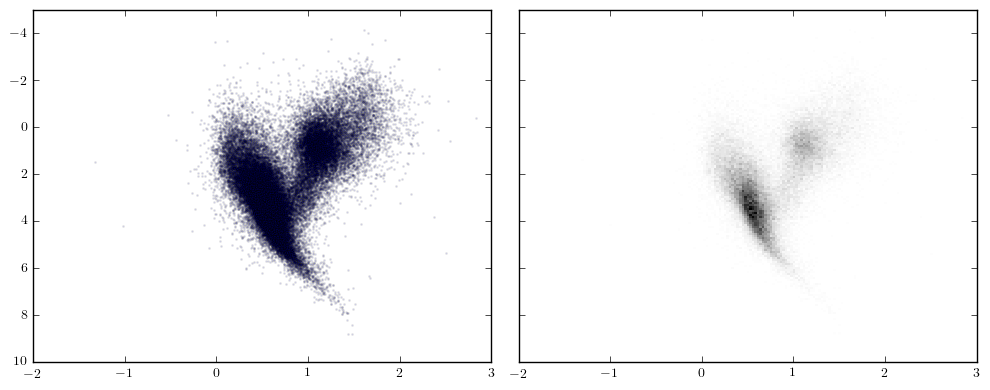

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ind2 = obscolors[:, 0] > -2
ind2 &= obscolors[:, 0] < 3
ind2 &= np.isfinite(ebv)
axs[0].scatter(obscolors[ind2, 0], obsabsmagG[ind2], s=1, alpha=0.1)
axs[1].hist2d(obscolors[ind2].ravel(), obsabsmagG[ind2], 150, cmap="gray_r")
axs[0].set_ylim([10, -5])
axs[0].set_xlim([-2, 3])
fig.tight_layout()

In [7]:
# Construct tiling of mag-color space
nbins_perdim = 40
finenbins_perdim = 160
nbins = nbins_perdim**(ncols+1)
lines = [np.linspace(-3, 9, nbins_perdim), np.linspace(-0.5, 2.5, nbins_perdim)]
flines = [np.linspace(-3, 9, finenbins_perdim), np.linspace(-0.5, 2.5, finenbins_perdim)]
mugrids = np.meshgrid(*lines)
siggrids = np.meshgrid(*[np.repeat((l[1]-l[0])/2, nbins_perdim) for l in lines])

binmus = np.vstack([g.ravel() for g in mugrids]).T
binsigs = np.vstack([g.ravel() for g in siggrids]).T

fgrids = np.meshgrid(*flines)
xfine = np.vstack([g.ravel() for g in fgrids]).T

In [8]:
dist_max = 2.5
ind = np.abs(ebv) < 2
ind &= np.isfinite(ebv)
ind &= 1/varpi < dist_max
ind &= obsabsmag > lines[0].min()
ind &= obsabsmag < lines[0].max()
for i in range(ncols):
    ind &= obscolors[:, i] > lines[i+1].min()
    ind &= obscolors[:, i] < lines[i+1].max()
varpi = varpi[ind]
varpi_err = varpi_err[ind]
obsmags = obsmags[ind]
obsmags_err = obsmags_err[ind]
obscolors = obscolors[ind, :]
obscolors_err = obscolors_err[ind, :]
obsabsmag = obsabsmag[ind]
nobj = ind.sum()
print(nobj)

49550


In [9]:
distances = 1./varpi
probgrid = np.zeros((nobj, nbins))
binamps = np.repeat(1./nbins, nbins)
prob_bingrid_marg(
    probgrid, nobj, nbins, ncols,
    varpi, varpi_err, obsmags, obsmags_err,
    obscolors, obscolors_err,
    distances, binamps, binmus, binsigs)
bins = np.argmax(probgrid, axis=1)
bincounts = np.bincount(bins, minlength=nbins)
binamps = np.random.dirichlet(bincounts)

def hrd(x, amps, mus, sigs):
    nbins = amps.size
    npoints, ndim = x.shape
    y = np.zeros((npoints, ))
    for b in range(nbins):
        y += amps[b] / nbins * np.prod(
            np.exp(-0.5*((x-mus[b, None, :])/sigs[b, None, :])**2) / 
                sigs[b, None, :]/np.sqrt(2*np.pi), axis=1)
    return y

naive_model = hrd(xfine, binamps, binmus, binsigs).reshape(fgrids[0].shape)

In [10]:
logdist_err = varpi_err * 5 / varpi / np.log(10)

In [11]:
stacked_counts = None
nsamp = 100
for i in range(nsamp):
    ran_colors = obscolors[:, 0] + obscolors_err[:, 0]*np.random.randn(nobj)
    ran_obsmags = obsmags[:] + obsmags_err[:]*np.random.randn(nobj)
    ran_dist = 1/(varpi[:] + varpi_err[:]*np.random.randn(nobj))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, range=[[lines[1][0], lines[1][-1]], 
                                                                  [lines[0][0], lines[0][-1]]],
                                 bins=[lines[0].size, lines[0].size])
    if stacked_counts is None:
        stacked_counts = counts / nsamp
    else:
        stacked_counts += counts / nsamp

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


In [12]:
# Arbitrary cut but 0 or 1 should be reasonnable
selection = np.where(stacked_counts.ravel() > 1.0)[0]
binamps = 1*stacked_counts.ravel() / np.sum(stacked_counts)
naive_model = hrd(xfine, binamps, binmus, binsigs).reshape(fgrids[0].shape)
#selection = np.where(bincounts > 0)[0]
binamps_selection = np.repeat(0, nbins)
binamps_selection[selection] = 1
selectionfct_model = hrd(xfine, binamps_selection, binmus, binsigs).reshape(fgrids[0].shape)
print(selection.size, nbins)

import scipy.ndimage.filters
binamps_selection2 = 1 - scipy.ndimage.filters.uniform_filter(1-binamps_selection.reshape(mugrids[0].shape), 
                                                          2, mode='nearest').ravel()
selectionfct_model2 = hrd(xfine, binamps_selection2, binmus, binsigs).reshape(fgrids[0].shape)
#selection = np.where(binamps_selection > 0)[0]
#print(selection.size, nbins)

917 1600


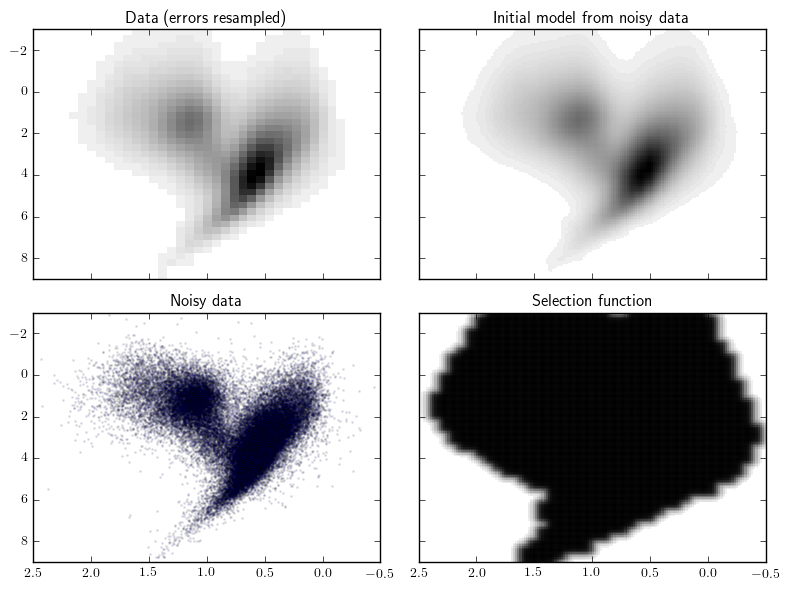

In [13]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].pcolormesh(lines[1], lines[0], stacked_counts.T, cmap=cmap, rasterized=True, lw=0)
axs[0].set_title('Data (errors resampled)')
axs[1].pcolormesh(fgrids[1], fgrids[0], naive_model, cmap=cmap, rasterized=True, lw=0)
axs[1].set_title('Initial model from noisy data')
axs[2].scatter(obscolors, obsabsmag, s=1, alpha=0.1)
axs[2].set_title('Noisy data')
axs[3].pcolormesh(fgrids[1], fgrids[0], selectionfct_model2, cmap=cmap, rasterized=True, lw=0)
axs[3].set_title('Selection function')
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
fig.tight_layout()

In [14]:
# validation : random subset of object. Add noise
# in the rest:
# training 1: all objects
# training 2: best objects
# training 3: worst objects
inds = np.arange(nobj)
np.random.shuffle(inds)
frac = 0.1
lim = int(frac*nobj)
ind_validation = inds[:lim]
ind_validation = ind_validation[(varpi_err/varpi)[ind_validation]**2 < 0.2]
ind_training = inds[lim:]
ind_training_sorted = ind_training[np.argsort((varpi_err/varpi)[ind_training])]
if ind_training_sorted.size % 2 == 0:
    ind_training_best, ind_training_worst = np.split(ind_training_sorted[:], 2)
else:
    ind_training_best, ind_training_worst = np.split(ind_training_sorted[:-1], 2)
snrlim = np.min((varpi/varpi_err)[ind_training_best])

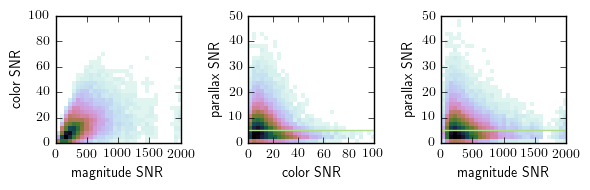

In [15]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(0.5)
tnbins = 31
fig, axs = plt.subplots(1, 3, figsize=(6, 2))
rr1, rr2, rr3 = 2001, 100, 50
axs[0].hist2d(
    obsmags[ind_training]/obsmags_err[ind_training], 
    obscolors[ind_training, 0]/obscolors_err[ind_training, 0],
    cmap=cmap, bins=tnbins, range=[[0, rr1], [0, rr2]])
axs[1].hist2d(
    obscolors[ind_training, 0]/obscolors_err[ind_training, 0], 
    varpi[ind_training]/varpi_err[ind_training],
    cmap=cmap, bins=tnbins, range=[[0, rr2], [0, rr3]])
axs[2].hist2d(
    obsmags[ind_training]/obsmags_err[ind_training], 
    varpi[ind_training]/varpi_err[ind_training],
    cmap=cmap, bins=tnbins, range=[[0, rr1], [0, rr3]])
axs[1].axhline(snrlim, c=cols[2])
axs[2].axhline(snrlim, c=cols[2])
axs[2].set_ylabel('parallax SNR')
axs[1].set_ylabel('parallax SNR')
axs[1].set_xlabel('color SNR')
axs[0].set_ylabel('color SNR')
axs[0].set_xlabel('magnitude SNR')
axs[2].set_xlabel('magnitude SNR')
fig.tight_layout()
fig.savefig('../paper/datasummary.pdf')

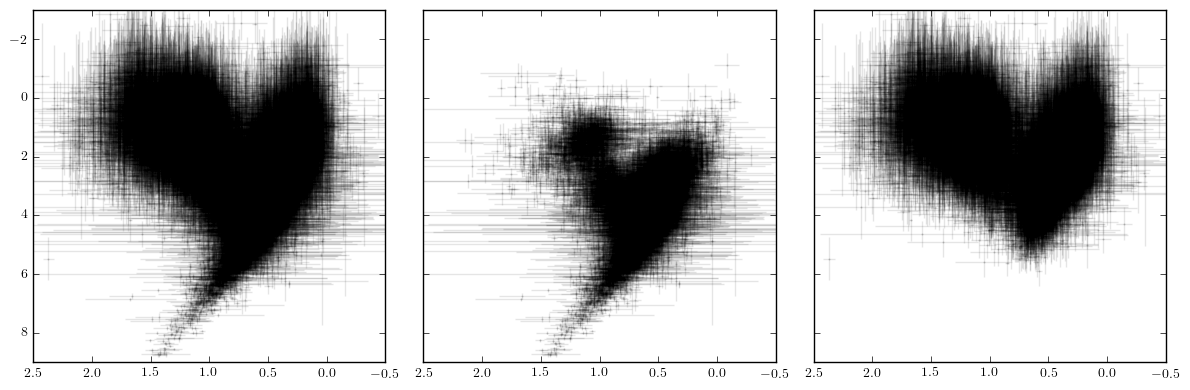

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
axs = axs.ravel()
yerr = np.sqrt(obsmags_err**2 + (logdist_err)**2)
xerr = obscolors_err
args = {'fmt': 'o', 'markersize': 1, 'color': 'k', 'lw': 1, 'capsize': 0, 'alpha': 0.1}
axs[0].errorbar(obscolors[ind_training],
                obsabsmag[ind_training], 
                yerr=yerr[ind_training],
                xerr=xerr[ind_training],
                **args)
axs[1].errorbar(obscolors[ind_training_best],
                obsabsmag[ind_training_best], 
                yerr=yerr[ind_training_best],
                xerr=xerr[ind_training_best], 
                **args)
axs[2].errorbar(obscolors[ind_training_worst],
                obsabsmag[ind_training_worst], 
                yerr=yerr[ind_training_worst],
                xerr=xerr[ind_training_worst], 
                **args)
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
fig.tight_layout()

(array([  8047.,  15562.,  10592.,   6515.,   3766.,   2146.,   1308.,
           815.,    493.,    306.]),
 array([ 0.01852947,  0.26667446,  0.51481945,  0.76296444,  1.01110944,
         1.25925443,  1.50739942,  1.75554441,  2.00368941,  2.2518344 ,
         2.49997939]),
 <a list of 10 Patch objects>)

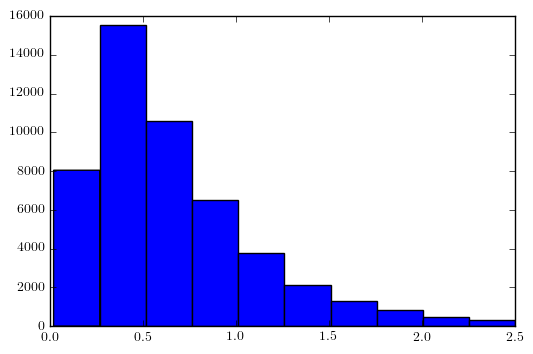

In [17]:
plt.hist(1/varpi)

In [18]:
# Apply selection function and drop unused bins
binamps_sel = binamps[selection]
binmus_sel, binsigs_sel = binmus[selection, :], binsigs[selection, :]
nbins_sel = selection.size

In [19]:
model = SimpleHRDModel()
num_samples = 5000
num_steps = 20

In [20]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training], varpi_err[ind_training],
               obsmags[ind_training], obsmags_err[ind_training],
               obscolors[ind_training, :], obscolors_err[ind_training, :])
dist_err = model.varpi_err / model.varpi**2
scale = np.clip(dist_err / np.max(dist_err) / 10, 1e-5, 1e-2)
distances_samples, bins_samples, binamps_samples =\
            model.gibbs_sampler(num_samples, num_steps=num_steps,
                                scale=scale, dist_max=dist_max)

Time per sample: 0.593355 s , 0.194542 s , 0.000753 s


In [21]:
distances_inf = distances_samples.mean(axis=0)
distances_inf_std = distances_samples.std(axis=0)
bins_sel_inf = bins_samples.mean(axis=0).astype(int)
binamps_inf, binamps_inf_std = 0*binamps, 0*binamps
binamps_inf[selection] = binamps_samples.mean(axis=0)
binamps_inf_std[selection] = binamps_samples.std(axis=0)
inf_model = hrd(xfine, binamps_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_model_std = hrd(xfine, binamps_inf_std, binmus, binsigs).reshape(fgrids[0].shape)
print(np.isfinite(distances_samples).sum() / num_samples == distances_samples.shape[1])

True


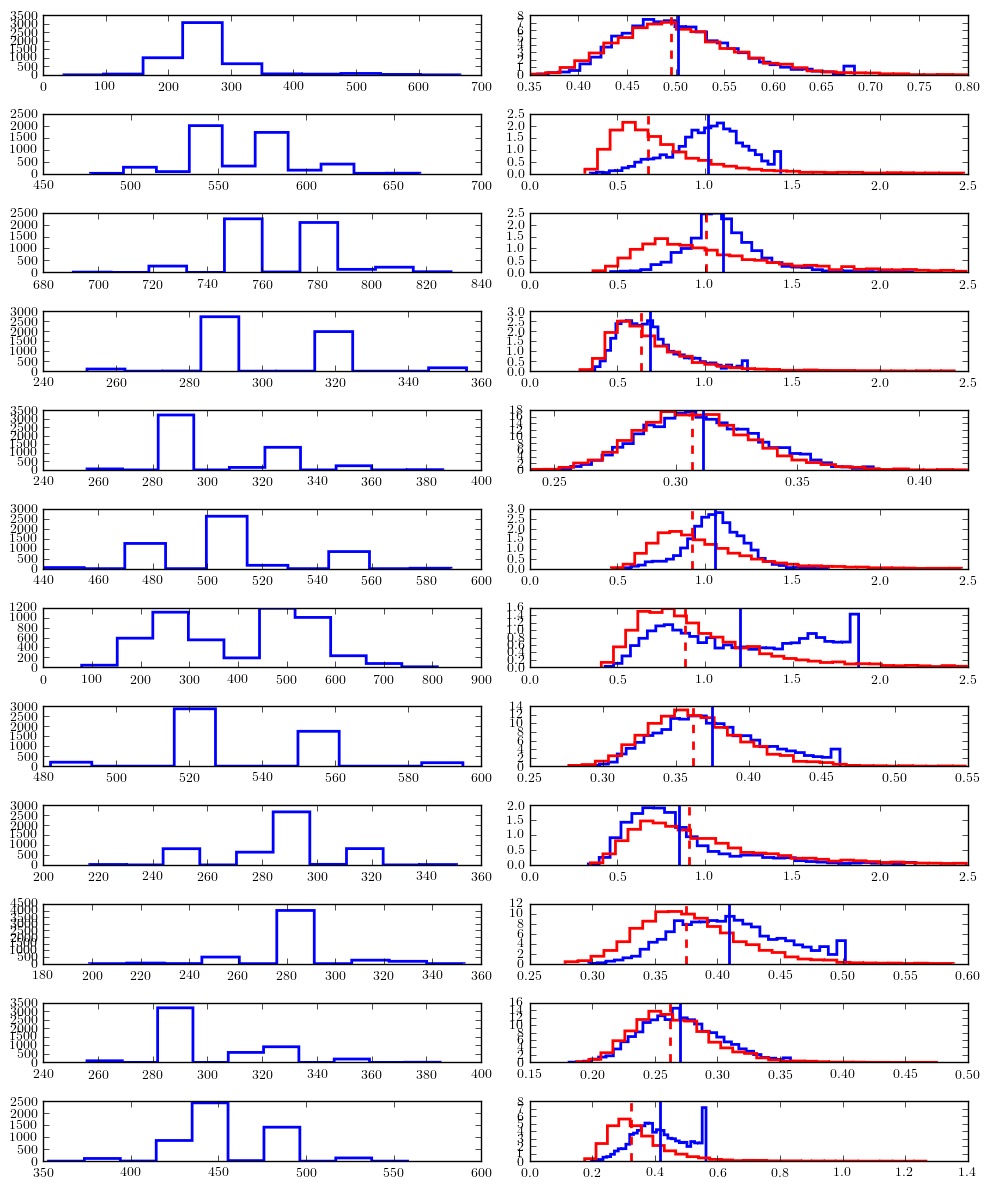

In [22]:
# shrinkage of distances in training set
# TODO: better representation of bin locations (in 2D plane with sample average)
distances_samples2 = np.vstack([1/(varpi[ind_training] + varpi_err[ind_training]*np.random.randn(ind_training.size)) for i in range(num_samples)])
distances = distances_samples.mean(axis=0)
distances2 = 1/varpi[ind_training]
fig, axs = plt.subplots(12, 2, figsize=(10, 12))
varpi_fracerror = varpi_err / varpi
js = np.arange(ind_training.size)
#js = np.where(dist_err < 0.01 )[0]
np.random.shuffle(js)
for i in range(axs.shape[0]):
    axs[i, 0].hist(bins_samples[:, js[i]], histtype='step', lw=2)
    axs[i, 1].hist(distances_samples[:, js[i]], 30, normed=True, color='b', histtype='step', lw=2)#, range=[0, dist_max])
    ind2 = distances_samples2[:, js[i]] > 0
    ind2 &= distances_samples2[:, js[i]] < dist_max
    axs[i, 1].hist(distances_samples2[ind2, js[i]], 30, normed=True, color='r', histtype='step', lw=2)#, range=[0, dist_max])
    axs[i, 1].axvline(distances[js[i]], c='b', lw=2)
    axs[i, 1].axvline(distances2[js[i]], c='r', lw=2, ls='--')
fig.tight_layout()

In [23]:
stacked_counts = None
nsamp = 100
for i in range(nsamp):
    ran_colors = obscolors[ind_training, 0] + obscolors_err[ind_training, 0]*np.random.randn(ind_training.size)
    ran_obsmags = obsmags[ind_training] + obsmags_err[ind_training]*np.random.randn(ind_training.size)
    ran_dist = 1/(varpi[ind_training] + varpi_err[ind_training]*np.random.randn(ind_training.size))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, bins=[flines[1], flines[0]])
    if stacked_counts is None:
        stacked_counts = counts / nsamp
    else:
        stacked_counts += counts / nsamp

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


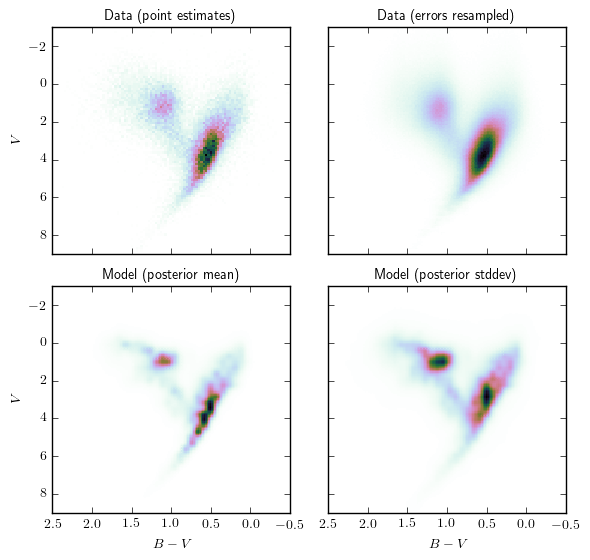

In [24]:
cmap = plt.cm.cubehelix_r # CMRmap #coolwarm# YlGnBu_r
cmap.set_gamma(1)
fig, axs = plt.subplots(2, 2, figsize=(6, 5.7), sharex=True, sharey=True)
axs = axs.ravel()
fs = 10
axs[0].hist2d(obscolors[:, 0], obsabsmag, 100,
              range=[[lines[1][0], lines[1][-1]], [lines[0][0], lines[0][-1]]],
              cmap=cmap, rasterized=True)
axs[0].set_title('Data (point estimates)', fontsize=fs)
axs[1].pcolormesh(flines[1], flines[0], stacked_counts.T, cmap=cmap, rasterized=True, lw=0)
axs[1].set_title('Data (errors resampled)', fontsize=fs)
axs[2].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap, rasterized=True, lw=0)
axs[2].set_title('Model (posterior mean)', fontsize=fs)
vs = axs[3].pcolormesh(fgrids[1], fgrids[0], inf_model_std, cmap=cmap, rasterized=True, lw=0)
axs[3].set_title('Model (posterior stddev)', fontsize=fs)
axs[0].set_ylim(lines[0][-1], lines[0][0])
axs[0].set_xlim(lines[1][-1], lines[1][0])
axs[2].set_xlabel(r'$B-V$')
axs[0].set_ylabel(r'$V$')
axs[3].set_xlabel(r'$B-V$')
axs[2].set_ylabel(r'$V$')
#clb = plt.colorbar(vs, ax=axs.ravel().tolist(), ticks=[])
fig.tight_layout()
#fig.subplots_adjust(wspace=.01, right=0.8)
fig.savefig('../paper/colmagdiag_mainsample.pdf')

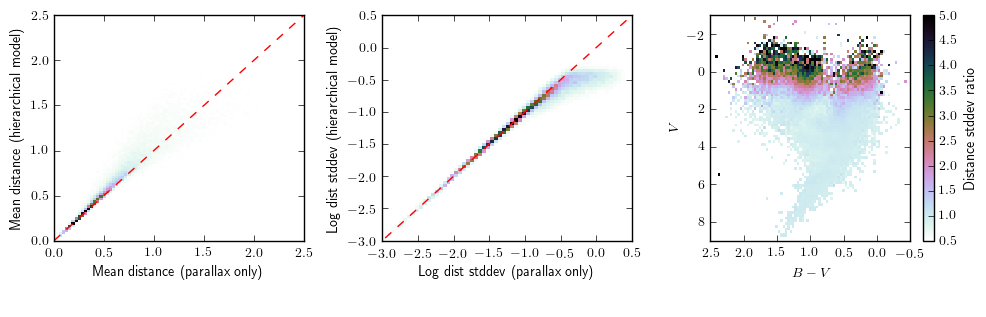

In [25]:
cmap = plt.cm.cubehelix_r
#cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.ravel()
tnbins = 80
axs[0].hist2d(1/varpi[ind_training], distances_inf, tnbins, cmap=cmap)
axs[0].plot([0, dist_max], [0, dist_max], c='r', ls='dashed')
axs[0].set_ylim([0, dist_max])
axs[0].set_xlim([0, dist_max])
axs[0].set_xlabel('Mean distance (parallax only)')
axs[0].set_ylabel('Mean distance (hierarchical model)')
dist_err = varpi_err[ind_training] / varpi[ind_training]**2
axs[1].hist2d(np.log10(dist_err), np.log10(distances_inf_std), tnbins, cmap=cmap)
axs[1].plot([-4, 1], [-4, 1], c='r', ls='dashed')
axs[1].set_ylim([-3, 0.5])
axs[1].set_xlim([-3, 0.5])
axs[1].set_xlabel('Log dist stddev (parallax only)')
axs[1].set_ylabel('Log dist stddev (hierarchical model)')
meanerrratio, xedges, yedges, binall = scipy.stats.binned_statistic_2d(
    obscolors[ind_training, 0], obsabsmag[ind_training], (dist_err/distances_inf_std), bins=tnbins)
meanerrratio[~np.isfinite(meanerrratio)] = 0
vs = axs[2].pcolormesh(xedges, yedges, meanerrratio.T, cmap=cmap, vmin=0.5, vmax=5, rasterized=True, lw=0)
clb = plt.colorbar(vs, ax=axs[-1])#.ravel().tolist())
clb.set_label('Distance stddev ratio')
axs[2].set_ylim(lines[0][-1], lines[0][0])
axs[2].set_xlim(lines[1][-1], lines[1][0])
axs[2].set_xlabel(r'$B-V$')
axs[2].set_ylabel(r'$V$')
fig.tight_layout()

In [26]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training_best], varpi_err[ind_training_best],
               obsmags[ind_training_best], obsmags_err[ind_training_best],
               obscolors[ind_training_best, :], obscolors_err[ind_training_best, :])
dist_err = model.varpi_err / model.varpi**2
scale = np.clip(dist_err / np.max(dist_err), 1e-5, 1e-2)
distances_samples_best, bins_samples_best, binamps_samples_best =\
            model.gibbs_sampler(num_samples, num_steps=num_steps,
                                scale=scale, dist_max=dist_max)
print(np.isfinite(distances_samples).sum() / num_samples, distances_samples.shape)

Time per sample: 0.3089 s , 0.115782 s , 0.000702737 s
44595.0 (5000, 44595)


In [27]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training_worst], varpi_err[ind_training_worst],
               obsmags[ind_training_worst], obsmags_err[ind_training_worst],
               obscolors[ind_training_worst, :], obscolors_err[ind_training_worst, :])
dist_err = model.varpi_err / model.varpi**2
scale = np.clip(dist_err / np.max(dist_err), 1e-5, 1e-2)
distances_samples_worst, bins_samples_worst, binamps_samples_worst =\
            model.gibbs_sampler(num_samples, num_steps=num_steps,
                                scale=scale, dist_max=dist_max)

Time per sample: 0.302929 s , 0.114508 s , 0.000697059 s


In [28]:
distances_best_inf = distances_samples_best.mean(axis=0)
binamps_best_inf, binamps_best_inf_std = 0*binamps, 0*binamps
binamps_best_inf[selection] = binamps_samples_best.mean(axis=0)
binamps_best_inf_std[selection] = binamps_samples_best.std(axis=0)
inf_best_model = hrd(xfine, binamps_best_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_best_model_std = hrd(xfine, binamps_best_inf_std, binmus, binsigs).reshape(fgrids[0].shape)
print(np.isfinite(distances_samples_best).sum() / num_samples == distances_samples_best.shape[1])

True


In [29]:
distances_worst_inf = distances_samples_worst.mean(axis=0)
binamps_worst_inf, binamps_worst_inf_std = 0*binamps, 0*binamps
binamps_worst_inf[selection] = binamps_samples_worst.mean(axis=0)
binamps_worst_inf_std[selection] = binamps_samples_worst.std(axis=0)
inf_worst_model = hrd(xfine, binamps_worst_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_worst_model_std = hrd(xfine, binamps_worst_inf_std, binmus, binsigs).reshape(fgrids[0].shape)
print(np.isfinite(distances_samples_worst).sum() / num_samples == distances_samples_worst.shape[1])

True


In [30]:
stacked_counts_best = None
nsamp = 100
for i in range(nsamp):
    ran_colors = obscolors[ind_training_best, 0] + obscolors_err[ind_training_best, 0]*np.random.randn(ind_training_best.size)
    ran_obsmags = obsmags[ind_training_best] + obsmags_err[ind_training_best]*np.random.randn(ind_training_best.size)
    ran_dist = 1/(varpi[ind_training_best] + varpi_err[ind_training_best]*np.random.randn(ind_training_best.size))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, bins=[flines[1], flines[0]])
    if stacked_counts_best is None:
        stacked_counts_best = counts / nsamp
    else:
        stacked_counts_best += counts / nsamp

In [31]:
stacked_counts_worst = None
nsamp = 100
for i in range(nsamp):
    ran_colors = obscolors[ind_training_worst, 0] + obscolors_err[ind_training_worst, 0]*np.random.randn(ind_training_worst.size)
    ran_obsmags = obsmags[ind_training_worst] + obsmags_err[ind_training_worst]*np.random.randn(ind_training_worst.size)
    ran_dist = 1/(varpi[ind_training_worst] + varpi_err[ind_training_worst]*np.random.randn(ind_training_worst.size))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, bins=[flines[1], flines[0]])
    if stacked_counts_worst is None:
        stacked_counts_worst = counts / nsamp
    else:
        stacked_counts_worst += counts / nsamp

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


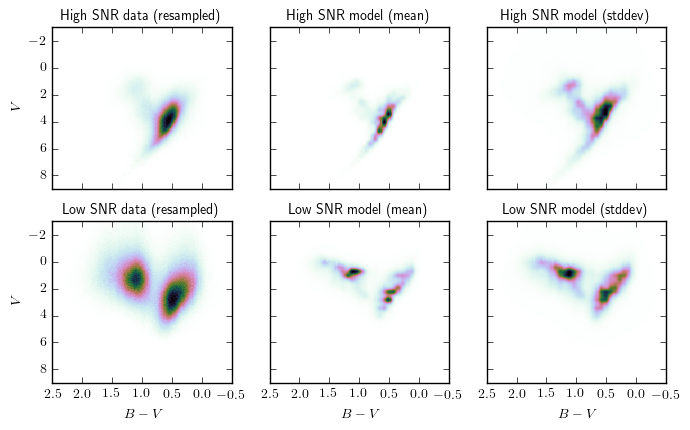

In [32]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(1)
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), sharex=True, sharey=True)
axs[0, 0].set_title('High SNR data (resampled)', fontsize=fs)
axs[0, 1].set_title('High SNR model (mean)', fontsize=fs)
axs[0, 2].set_title('High SNR model (stddev)', fontsize=fs)
axs[1, 0].set_title('Low SNR data (resampled)', fontsize=fs)
axs[1, 1].set_title('Low SNR model (mean)', fontsize=fs)
axs[1, 2].set_title('Low SNR model (stddev)', fontsize=fs)
axs[0, 0].pcolormesh(flines[1], flines[0], stacked_counts_best.T, cmap=cmap, rasterized=True, lw=0)
axs[0, 1].pcolormesh(fgrids[1], fgrids[0], inf_best_model, cmap=cmap, rasterized=True, lw=0)
axs[0, 2].pcolormesh(fgrids[1], fgrids[0], inf_best_model_std, cmap=cmap, rasterized=True, lw=0)
axs[1, 0].pcolormesh(flines[1], flines[0], stacked_counts_worst.T, cmap=cmap, rasterized=True, lw=0)
axs[1, 1].pcolormesh(fgrids[1], fgrids[0], inf_worst_model, cmap=cmap, rasterized=True, lw=0)
axs[1, 2].pcolormesh(fgrids[1], fgrids[0], inf_worst_model_std, cmap=cmap, rasterized=True, lw=0)
axs[0, 0].set_ylim(lines[0][-1], lines[0][0])
axs[0, 0].set_xlim(lines[1][-1], lines[1][0])
for i in range(3):
    axs[1, i].set_xlabel(r'$B-V$')
for i in range(2):
    axs[i, 0].set_ylabel(r'$V$')
fig.tight_layout()
fig.savefig('../paper/colmagdiag_othersamples.pdf')

In [ ]:
# shrinkage of distances in training set
distances_grid = np.linspace(0.001, dist_max, 500)
probgrid_mean = np.zeros((ind_training.size, distances_grid.size))
binamps_sel_val = binamps_samples.mean(axis=0)
prob_distgrid_marg(
                probgrid_mean, distances_grid.size, distances_grid,
                ind_training.size, nbins_sel, ncols,
                varpi[ind_training], varpi_err[ind_training],
                obsmags[ind_training], obsmags_err[ind_training],
                obscolors[ind_training, :], obscolors_err[ind_training, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_training.size, distances_grid.size))
binamps_sel_val[:] = 1./nbins
prob_distgrid_marg(
                probgrid_flat, distances_grid.size, distances_grid,
                ind_training.size, nbins_sel, ncols,
                varpi[ind_training], varpi_err[ind_training],
                obsmags[ind_training], obsmags_err[ind_training],
                obscolors[ind_training, :], obscolors_err[ind_training, :],
                binamps_sel_val, binmus_sel, binsigs_sel)
mean_vals1 = np.zeros((ind_training.size, ))
std_vals1 = np.zeros((ind_training.size, ))
mean_vals2 = np.zeros((ind_training.size, ))
std_vals2 = np.zeros((ind_training.size, ))
for o in range(ind_training.size):
    if probgrid_mean[o, :].sum() > 0:
        mean_vals2[o] = np.average(distances_grid, weights=probgrid_mean[o, :])
        std_vals2[o] = np.average((distances_grid - mean_vals2[o])**2, weights=probgrid_mean[o, :])**0.5
    if probgrid_flat[o, :].sum() > 0:
        mean_vals1[o] = np.average(distances_grid, weights=probgrid_flat[o, :])
        std_vals1[o] = np.average((distances_grid - mean_vals1[o])**2, weights=probgrid_flat[o, :])**0.5

In [ ]:
ratio = std_vals1[std_vals2 > 0]/std_vals2[std_vals2 > 0]
print(np.percentile(ratio, [5, 50, 95]))
print((std_vals1/std_vals2 > 2).sum() / std_vals1.size)

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(7, 5), sharex=True, sharey=True)
#for i in range(axs.shape[0]):
    #axs[i, 0].set_ylabel('Posterior distribution')
for i in range(axs.shape[1]):
    axs[-1, i].set_xlabel('Distance [kpc]')
axs = axs.ravel()
dist_val = 1/varpi[ind_training]
dist_err_val = varpi_err[ind_training] / varpi[ind_training]**2
snr1 = mean_vals1 / std_vals1
snr2 = mean_vals2 / std_vals2
ind3 = snr2 > snr1 * 1.2
ind3 &= snr2 < 10
js = np.random.choice(np.where(ind3)[0], axs.size, replace=False)#
for i in range(axs.size):
    y = probgrid_flat[js[i], :]/np.max(probgrid_flat[js[i], :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c=cols[0], lw=2, label='parallax only')
    y = probgrid_mean[js[i], :]/np.max(probgrid_mean[js[i], :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c=cols[1], lw=2, label='hierarchical model')
    axs[i].set_yticks([])
    axs[i].set_ylim([0, 1.1])
    axs[i].set_title('SNR: %.1f' % snr1[js[i]] + r'$\rightarrow$' + '%.1f' % snr2[js[i]], fontsize=9)
    #axs[i].text(1.35, 0.85, 'SNR: %.1f' % snr1[js[i]] + r'$\rightarrow$' + '%.1f' % snr2[js[i]],
    #            fontsize=9, bbox=dict(facecolor='white', edgecolor='w', pad=0, alpha=0.75))
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 2))
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('../paper/model_dist_pdfs.pdf')

In [ ]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(2, 2, figsize=(6, 5.5))
axs = axs.ravel()
tnbins = 60
axs[0].hist2d(mean_vals1, mean_vals2, tnbins, cmap=cmap)
axs[0].plot([0, dist_max], [0, dist_max], c='r', ls='dashed')
axs[0].set_ylim([0, dist_max])
axs[0].set_xlim([0, dist_max])
axs[0].set_xlabel('Mean distance (parallax only)')
axs[0].set_ylabel('Mean distance (hierarchical model)')
ind = std_vals1 > 0
ind &= std_vals2 > 0
rrr = -3
axs[1].hist2d(np.log10(std_vals1[ind]), np.log10(std_vals2[ind]), tnbins, range=[[-4, 0], [-4, 0]], cmap=cmap)
axs[1].plot([rrr, 0], [rrr, 0], c='r', ls='dashed')
axs[1].set_ylim([rrr, 0])
axs[1].set_xlim([rrr, 0])
axs[1].set_xlabel('Log dist stddev (parallax only)')
axs[1].set_ylabel('Log dist stddev (hierarchical model)')

rrr = 20
snr1 = mean_vals1 / std_vals1
snr2 = mean_vals2 / std_vals2
axs[2].plot([1, rrr], [1, rrr], c='r', ls='dashed')
axs[2].hist2d(snr1, snr2, tnbins, cmap=cmap, range=[[1, rrr], [1, rrr]])
axs[2].set_xlabel('Distance SNR (parallax only)')
axs[2].set_ylabel('Distance SNR (hierarchical model)')

meanerrratio, xedges, yedges, binall = scipy.stats.binned_statistic_2d(
    obscolors[ind_training, 0], obsabsmag[ind_training], (std_vals2/std_vals1), bins=tnbins)
meanerrratio[~np.isfinite(meanerrratio)] = 0
vs = axs[3].pcolormesh(xedges, yedges, meanerrratio.T, cmap=cmap, vmin=1, vmax=2, rasterized=True, lw=0)
clb = plt.colorbar(vs, ax=axs[-1])#.ravel().tolist())
clb.set_label('Distance stddev ratio')
axs[3].set_ylim(lines[0][-1], lines[0][0])
axs[3].set_xlim(lines[1][-1], lines[1][0])
axs[3].set_xlabel(r'$B-V$')
axs[3].set_ylabel(r'$V$')
fig.tight_layout()
fig.savefig('../paper/colmagdiag_mainsample_dist.pdf')

In [ ]:
stop

In [36]:
# noisyfying parallaxes of validation sample
varpi_err_val = varpi_err[ind_validation]
varpi_val = varpi[ind_validation]
extra_varpi_err_val = varpi_err_val * 5
varpi_val += extra_varpi_err_val * np.random.randn(ind_validation.size)
varpi_err_val = np.sqrt(varpi_err_val**2 + extra_varpi_err_val**2)

In [37]:
# shrinkage of distances in validation set
distances_grid = np.linspace(0.001, dist_max, 500)
probgrid_mean = np.zeros((ind_validation.size, distances_grid.size))
binamps_sel_val = binamps_samples.mean(axis=0)
prob_distgrid_marg(
                probgrid_mean, distances_grid.size, distances_grid,
                ind_validation.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_validation], obsmags_err[ind_validation],
                obscolors[ind_validation, :], obscolors_err[ind_validation, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_validation.size, distances_grid.size))
binamps_sel_val[:] = 1./nbins
prob_distgrid_marg(
                probgrid_flat, distances_grid.size, distances_grid,
                ind_validation.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_validation], obsmags_err[ind_validation],
                obscolors[ind_validation, :], obscolors_err[ind_validation, :],
                binamps_sel_val, binmus_sel, binsigs_sel)
mean_vals1 = np.zeros((ind_validation.size, ))
std_vals1 = np.zeros((ind_validation.size, ))
mean_vals2 = np.zeros((ind_validation.size, ))
std_vals2 = np.zeros((ind_validation.size, ))
for o in range(ind_validation.size):
    mean_vals2[o] = np.average(distances_grid, weights=probgrid_mean[o, :])
    mean_vals1[o] = np.average(distances_grid, weights=probgrid_flat[o, :])
    std_vals1[o] = np.average((distances_grid - mean_vals1[o])**2, weights=probgrid_flat[o, :])**0.5
    std_vals2[o] = np.average((distances_grid - mean_vals2[o])**2, weights=probgrid_mean[o, :])**0.5

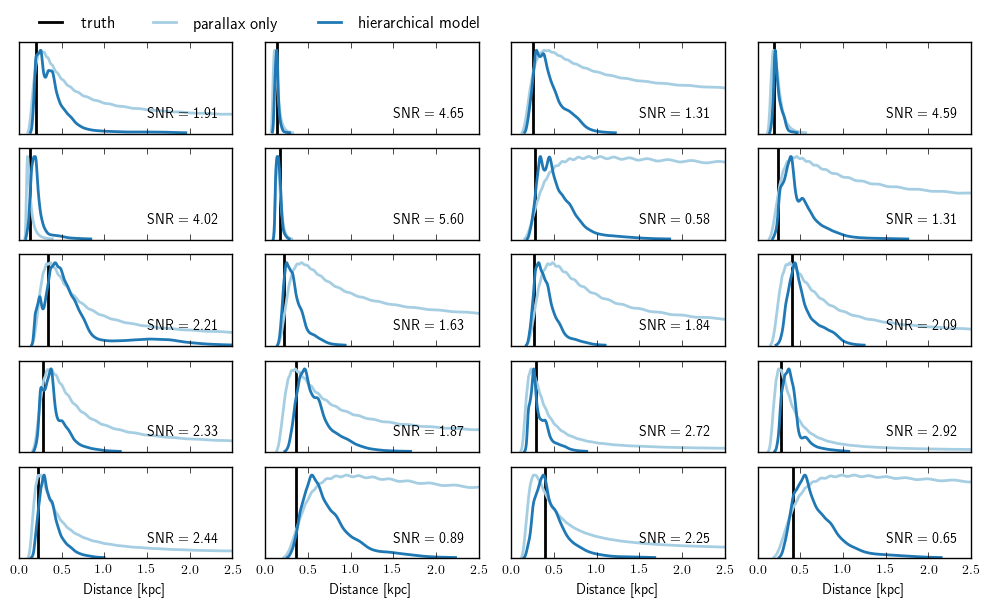

In [38]:
fig, axs = plt.subplots(5, 4, figsize=(10, 6), sharex=True, sharey=True)
#for i in range(axs.shape[0]):
    #axs[i, 0].set_ylabel('Posterior distribution')
for i in range(axs.shape[1]):
    axs[-1, i].set_xlabel('Distance [kpc]')
axs = axs.ravel()
dist_val = 1/varpi[ind_validation]
dist_err_val = varpi_err[ind_validation] / varpi[ind_validation]**2
ind3 = varpi_val > 0
ind3 &= dist_err_val < 0.05
js = np.random.choice(np.where(ind3)[0], axs.size, replace=False)#
for i in range(axs.size):
    #axs[i].axvspan(dist_val[js[i]]-dist_err_val[js[i]], dist_val[js[i]]+dist_err_val[js[i]],  color='gray', alpha=0.5)
    axs[i].axvline(dist_val[js[i]], color='k', label='truth', lw=2)
    y = probgrid_flat[js[i], :]/np.max(probgrid_flat[js[i], :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c=cols[0], lw=2, label='parallax only')
    y = probgrid_mean[js[i], :]/np.max(probgrid_mean[js[i], :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c=cols[1], lw=2, label='hierarchical model')
    axs[i].set_yticks([])
    axs[i].set_ylim([0, 1.1])
    axs[i].text(1.5, 0.2, 'SNR = %.2f' % (varpi_val[js[i]]/varpi_err_val[js[i]]))
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.45))
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.savefig('../paper/cv_noisified_pdfs.pdf')

(0, 2)

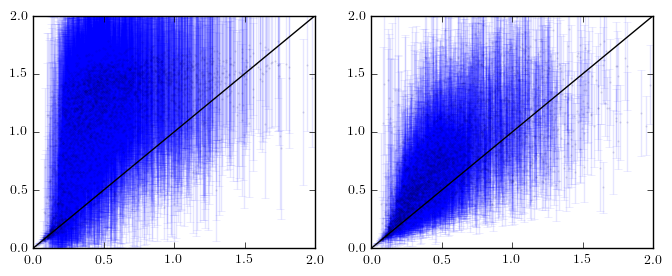

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
ind = dist_err_val > 0#.1
rr = 2
axs[0].errorbar(dist_val[ind], mean_vals1[ind], yerr=std_vals1[ind], fmt='o', markersize=1, alpha=0.1)
axs[1].errorbar(dist_val[ind], mean_vals2[ind], yerr=std_vals2[ind], fmt='o', markersize=1, alpha=0.1)
axs[0].plot([0, rr], [0, rr], c='k')
axs[1].plot([0, rr], [0, rr], c='k')
axs[0].set_xlim([0, rr])
axs[0].set_ylim([0, rr])
axs[1].set_xlim([0, rr])
axs[1].set_ylim([0, rr])

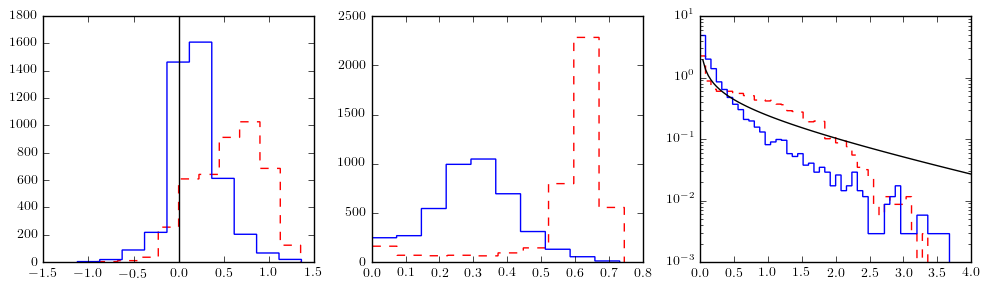

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].hist(mean_vals1-dist_val, histtype='step', color='r', ls='--')
axs[0].hist(mean_vals2-dist_val, histtype='step', color='b')
axs[0].axvline(0, c='k')
axs[1].hist(std_vals1, histtype='step', color='r', ls='--')
axs[1].hist(std_vals2, histtype='step', color='b')
chi1s = (mean_vals1 - dist_val)**2 / std_vals1
chi2s = (mean_vals2 - dist_val)**2 / std_vals2
rr = 4
from scipy.stats import chi2
x = np.linspace(0, rr, 100)
axs[2].hist(chi1s, 50, histtype='step', color='r', ls='--', range=[0, rr], normed=True)
axs[2].hist(chi2s, 50, histtype='step', color='b', range=[0, rr], normed=True)
axs[2].plot(x, chi2.pdf(x, 1), c='k')
axs[2].set_xlim([0, rr])
axs[2].set_yscale('log')
fig.tight_layout()

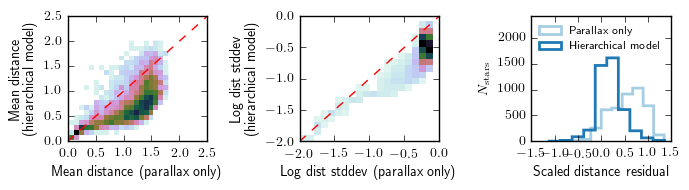

In [41]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 3, figsize=(7, 2))
axs = axs.ravel()
tnbins = 20
axs[0].hist2d(mean_vals1, mean_vals2, tnbins, cmap=cmap)
axs[0].plot([0, dist_max], [0, dist_max], c='r', ls='dashed')
axs[0].set_ylim([0, dist_max])
axs[0].set_xlim([0, dist_max])
axs[0].set_xlabel('Mean distance (parallax only)')
axs[0].set_ylabel('Mean distance\n (hierarchical model)')
ind = std_vals1 > 0
ind &= std_vals2 > 0
rrr = -2
axs[1].hist2d(np.log10(std_vals1[ind]), np.log10(std_vals2[ind]), tnbins, range=[[rrr, 0], [rrr, 0]], cmap=cmap)
axs[1].plot([rrr, 0], [rrr, 0], c='r', ls='dashed')
axs[1].set_ylim([rrr, 0])
axs[1].set_xlim([rrr, 0])
axs[1].set_xlabel('Log dist stddev (parallax only)')
axs[1].set_ylabel('Log dist stddev\n (hierarchical model)')

axs[2].hist(mean_vals1-dist_val, histtype='step', color=cols[0], lw=2, label='Parallax only')
counts, e, _ = axs[2].hist(mean_vals2-dist_val, histtype='step', color=cols[1], lw=2, label='Hierarchical model')
#axs[2].axvline(0, c='k')
axs[2].legend(loc='upper right', frameon=False, fontsize=8)
axs[2].set_ylim([0, 1.5*np.max(counts)])
axs[2].set_xlabel('Scaled distance residual')
axs[2].set_ylabel('$N_\mathrm{stars}$')

fig.tight_layout()
fig.savefig('../paper/cv_metrics.pdf')

In [42]:
ratio = std_vals1[std_vals2 > 0]/std_vals2[std_vals2 > 0]
print(np.percentile(ratio, [5, 50, 95]))
print((std_vals1/std_vals2 > 2).sum() / std_vals1.size)

[ 1.10442146  1.97495875  3.66027782]
0.483983286908


NameError: name 'stop' is not defined

In [ ]:
stop

In [ ]:
clname = 'Praesepe' #     'Pleiades' #'Blanco1'  # 'NGC6475' # 
fname = '../cluster_sources/'+clname+'-tgas-apassdr9-members.csv'
data = Table.read(fname).to_pandas()
data.columns

In [ ]:
varpi = data[['parallax']].values.ravel().astype(np.double)
varpi_err = data[['parallax_error']].values.ravel().astype(np.double)
varpi_err = np.sqrt(varpi_err**2 + 0.3**2)

obsmags = data[['vjmag']].values.astype(np.double).ravel()
obsmags_err = data[['evjmag']].values.astype(np.double).ravel()

ncols = 1
obscolors = data[['bjmag']].values.astype(np.double) - obsmags[:, None]
obscolors_err = np.sqrt(data[['ebjmag']].values.astype(np.double)**2 + obsmags_err[:, None]**2)

oc_dist = data[['OC_dist']].values.astype(np.double).ravel()

In [ ]:
distances_grid = np.linspace(0.001, 1.0, 300)
nobj = len(data)
probgrid_mean = np.zeros((nobj, distances_grid.size))
binamps_sel_val = binamps_samples.mean(axis=0)

prob_distgrid_marg(
                probgrid_mean, distances_grid.size, distances_grid,
                nobj, nbins_sel, ncols,
                varpi[:], varpi_err[:],
                obsmags[:], obsmags_err[:],
                obscolors[:, :], obscolors_err[:, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_training_worst.size, distances_grid.size))
binamps_sel_val[:] = 1./nbins
prob_distgrid_marg(
                probgrid_flat, distances_grid.size, distances_grid,
                nobj, nbins_sel, ncols,
                varpi[:], varpi_err[:],
                obsmags[:], obsmags_err[:],
                obscolors[:, :], obscolors_err[:, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(10, 8), sharex=False, sharey=True)
axs = axs.ravel()
for i in range(axs.size):
    y = probgrid_mean[i, :]/np.max(probgrid_mean[i, :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='b', lw=2)
    y = probgrid_flat[i, :]/np.max(probgrid_flat[i, :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='r', lw=2, ls='--')
    axs[i].set_yticks([])
    axs[i].axvline(oc_dist[i], color='k')
fig.tight_layout()

In [ ]:
mean_vals1 = np.zeros((nobj, ))
std_vals1 = np.zeros((nobj, ))
mean_vals2 = np.zeros((nobj, ))
std_vals2 = np.zeros((nobj, ))
for o in range(nobj):
    if probgrid_mean[o, :].sum() > 0 and probgrid_flat[o, :].sum() > 0:
        mean_vals2[o] = np.average(distances_grid, weights=probgrid_mean[o, :])
        mean_vals1[o] = np.average(distances_grid, weights=probgrid_flat[o, :])
        std_vals1[o] = np.average((distances_grid - mean_vals1[o])**2, weights=probgrid_flat[o, :])**0.5
        std_vals2[o] = np.average((distances_grid - mean_vals2[o])**2, weights=probgrid_mean[o, :])**0.5

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(8, 2.2))
rr = 15
s = 5

plt.suptitle(clname, fontsize=12)

axs[0].scatter((mean_vals1-oc_dist[0]), (mean_vals2-oc_dist[0]))
rrr = 0.09
axs[0].plot([-rrr, rrr], [-rrr, rrr], color='k')
axs[0].set_ylim([-rrr, rrr])
axs[0].set_xlim([-rrr, rrr])
axs[0].set_ylabel('Distance residual\n (hierarchical model)')
axs[0].set_xlabel('Distance residual\n (parallax only)')

axs[1].scatter(mean_vals1/std_vals1,
              mean_vals2/std_vals2)
axs[1].plot([0, rr], [0, rr], color='k')
axs[1].set_xlim([1, rr])
axs[1].set_ylim([1, rr])
axs[1].set_ylabel('Distance SNR\n (hierarchical model)')
axs[1].set_xlabel('Distance SNR\n (parallax only)')

y1 = 0.9*np.min([mean_vals1 - std_vals1, mean_vals2 - std_vals2])
y2 = 1.1*np.max([mean_vals1 + std_vals1, mean_vals2 + std_vals2])

axs[2].errorbar(mean_vals1/std_vals1, mean_vals1, yerr=std_vals1, fmt="o", markersize=s, color=cols[0])
axs[2].axhline(oc_dist[0], color='k')
axs[2].set_xlabel('Distance SNR')
axs[2].set_ylabel('Distance')
axs[2].text(3, 0.9*y2, 'Parallax only')
axs[2].set_ylim([y1, y2])
axs[2].set_xlim([1, rr])

axs[3].errorbar(mean_vals1/std_vals1, mean_vals2, yerr=std_vals2, fmt="o", markersize=s, color=cols[1])
axs[3].axhline(oc_dist[0], color='k')
axs[3].set_xlabel('Distance SNR')
axs[3].set_ylabel('Distance')
axs[3].text(2.3, 0.9*y2, 'Hierarchical model')
axs[3].set_ylim([y1, y2])
axs[3].set_xlim([1, rr])
                  
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.savefig('../paper/'+clname+'_metrics.pdf')

In [ ]:
plt.pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap)
plt.scatter(obscolors, obsmags + 5*np.log10(varpi) - 10)
plt.ylim(lines[0][-1], lines[0][0])
plt.xlim(lines[1][-1], lines[1][0])